# %% [markdown]

 # Pré-traitement Guidé par l'EDA - Chicago Taxi Trips (Échantillon)

 Ce notebook applique les premières étapes de pré-traitement identifiées lors de l'analyse exploratoire (EDA) précédente sur l'échantillon du dataset Chicago Taxi Trips. L'objectif est de préparer un jeu de données plus propre et cohérent pour une éventuelle modélisation.

 Étapes implémentées :
 1.  **Définition du périmètre et Filtrage :** Exclure les courses jugées non pertinentes ou erronées.
 2.  **Traitement des Valeurs Manquantes :** Supprimer les colonnes inutilisables et imputer les valeurs manquantes restantes.
 3.  **Gestion des Outliers et Transformations :** Appliquer la transformation logarithmique aux variables clés.
 4.  **Sélection Initiale de Features :** Choisir un ensemble de variables pour une première modélisation.

 Nous effectuerons également des vérifications après chaque étape pour valider le processus.

In [1]:
# %% [code]

# Import des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Configuration d'affichage
%matplotlib inline
sns.set(style="whitegrid", context="notebook") # Adapter le contexte pour un notebook
base_palette = sns.color_palette("viridis", 8)
sns.set_palette(base_palette)

# Supprimer les warnings (optionnel)
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]

 ## 1. Chargement et Nettoyage Initial de Base
 Chargement, nettoyage minimal des noms de colonnes, et conversions de types essentiels.

In [2]:
# %% [code]

# Chargement du dataset
try:
    df = pd.read_csv('../data/chicago_taxi_sample.csv')
    print(f"Dataset initial chargé avec succès. Forme: {df.shape}")
except FileNotFoundError:
    print("Erreur : Fichier '../data/chicago_taxi_sample.csv' non trouvé.")
    exit()

# Nettoyage initial des noms de colonnes
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print(f"Noms des colonnes nettoyés.")

# Conversion initiale des types
print("\nConversion initiale des types...")
# Timestamps
for col in ['trip_start_timestamp', 'trip_end_timestamp']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
# Numériques clés
cols_numeric = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total']
for col in cols_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
print("Conversion initiale des types terminée.")

# Création de 'trip_minutes' pour faciliter les filtres et analyses
if 'trip_seconds' in df.columns:
    df['trip_minutes'] = df['trip_seconds'] / 60
    print("Colonne 'trip_minutes' créée.")

Dataset initial chargé avec succès. Forme: (100000, 23)
Noms des colonnes nettoyés.

Conversion initiale des types...
Conversion initiale des types terminée.
Colonne 'trip_minutes' créée.


# %% [markdown]

 ## 2. Étape 1 : Définition du Périmètre de Modélisation et Filtrage
 Sur la base de l'EDA précédente, nous filtrons les courses qui ne correspondent pas à un trajet "standard" payant ou qui présentent des erreurs évidentes.

 **Critères de filtrage (Exemples à adapter si nécessaire) :**
 - Durée (`trip_minutes`) doit être supérieure à 0.
 - Distance (`trip_miles`) doit être supérieure à 0.
 - Tarif (`fare`) doit être supérieur à 0.
 - Le timestamp de fin doit être strictement postérieur au timestamp de début.
 - Optionnel: Exclure les vitesses moyennes irréalistes (très basses ou très hautes).

In [3]:
# %% [code]

print(f"Forme du DataFrame avant filtrage : {df.shape}")

# Initialiser le filtre comme une série de True
valid_rows = pd.Series(True, index=df.index)

# Appliquer les filtres conditionnellement si les colonnes existent
if 'trip_minutes' in df.columns:
    initial_invalid_duration = (df['trip_minutes'] <= 0) | df['trip_minutes'].isnull()
    print(f"Nombre de lignes avec durée <= 0 ou NaN : {initial_invalid_duration.sum()}")
    valid_rows &= ~initial_invalid_duration # Garder seulement où la condition est FAUSSE

if 'trip_miles' in df.columns:
    initial_invalid_distance = (df['trip_miles'] <= 0) | df['trip_miles'].isnull()
    print(f"Nombre de lignes avec distance <= 0 ou NaN : {initial_invalid_distance.sum()}")
    valid_rows &= ~initial_invalid_distance

if 'fare' in df.columns:
    initial_invalid_fare = (df['fare'] <= 0) | df['fare'].isnull()
    print(f"Nombre de lignes avec tarif <= 0 ou NaN : {initial_invalid_fare.sum()}")
    valid_rows &= ~initial_invalid_fare

if 'trip_start_timestamp' in df.columns and 'trip_end_timestamp' in df.columns:
    initial_invalid_time_order = (df['trip_end_timestamp'] <= df['trip_start_timestamp']) | df['trip_start_timestamp'].isnull() | df['trip_end_timestamp'].isnull()
    print(f"Nombre de lignes avec fin <= début ou timestamps NaN : {initial_invalid_time_order.sum()}")
    valid_rows &= ~initial_invalid_time_order

# # Optionnel : Filtrage basé sur la vitesse (à calculer d'abord si pas déjà fait)
# if 'trip_minutes' in df.columns and 'trip_miles' in df.columns:
#     # Recalculer la vitesse pour être sûr
#     speed = df['trip_miles'] / (df['trip_minutes'].replace(0, np.nan) / 60)
#     speed.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # Définir des limites de vitesse réalistes (ex: 1 mph à 80 mph)
#     lower_speed_bound = 1
#     upper_speed_bound = 80
#     invalid_speed = (speed < lower_speed_bound) | (speed > upper_speed_bound) | speed.isnull()
#     print(f"Nombre de lignes avec vitesse irréaliste (<{lower_speed_bound} ou >{upper_speed_bound} mph) ou NaN : {invalid_speed.sum()}")
#     valid_rows &= ~invalid_speed


# Appliquer le filtre combiné
df_filtered = df[valid_rows].copy() # Utiliser .copy() pour éviter SettingWithCopyWarning

print(f"\nForme du DataFrame après filtrage : {df_filtered.shape}")
print(f"Nombre de lignes supprimées : {df.shape[0] - df_filtered.shape[0]}")
print(f"Pourcentage de lignes conservées : {100 * df_filtered.shape[0] / df.shape[0]:.2f}%")

Forme du DataFrame avant filtrage : (100000, 24)
Nombre de lignes avec durée <= 0 ou NaN : 13401
Nombre de lignes avec distance <= 0 ou NaN : 27220
Nombre de lignes avec tarif <= 0 ou NaN : 616
Nombre de lignes avec fin <= début ou timestamps NaN : 41258

Forme du DataFrame après filtrage : (52969, 24)
Nombre de lignes supprimées : 47031
Pourcentage de lignes conservées : 52.97%


# %% [markdown]

 **Vérification Post-Filtrage :** Examinons rapidement les statistiques descriptives des variables clés après ce premier nettoyage majeur.

In [4]:
# %% [code]

print("\nStatistiques descriptives (après filtrage) pour les colonnes clés:")
cols_to_describe = [c for c in ['trip_minutes', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total'] if c in df_filtered.columns]
if cols_to_describe:
    print(df_filtered[cols_to_describe].describe())
else:
    print("Aucune colonne clé à décrire.")


Statistiques descriptives (après filtrage) pour les colonnes clés:
       trip_minutes    trip_miles          fare          tips         tolls  \
count  52969.000000  52969.000000  52969.000000  52969.000000  47757.000000   
mean      24.658282      7.889440     22.973801      2.189215      0.004125   
std       39.925020      8.953339     31.833498      4.129799      0.125472   
min        0.200000      0.010000      0.010000      0.000000      0.000000   
25%       10.550000      1.600000      8.250000      0.000000      0.000000   
50%       17.316667      4.290000     14.500000      0.000000      0.000000   
75%       30.566667     12.900000     35.000000      2.890000      0.000000   
max     1385.300000    515.900000   5100.250000    118.180000     11.140000   

             extras    trip_total  
count  52969.000000  52969.000000  
mean       2.666034     27.945270  
std        7.110164     36.246217  
min        0.000000      0.010000  
25%        0.000000      9.500000  
50% 

# %% [markdown]

 **Constat Post-Filtrage :** Le filtrage a supprimé une part *substantielle* des données de l'échantillon initial, confirmant la forte présence de trajets non standards ou erronés. Les valeurs minimales pour la durée, la distance et le tarif sont maintenant > 0.

# %% [markdown]

 ## 3. Étape 2 : Traitement Final des Valeurs Manquantes
 Suppression des colonnes inutilisables (trop de manquants) et imputation des valeurs manquantes restantes sur le DataFrame filtré.

In [5]:
# %% [code]

print(f"Forme avant traitement des manquants : {df_filtered.shape}")

# 1. Suppression des colonnes avec taux de manquants prohibitif (basé sur EDA précédente)
cols_to_drop = [
    'pickup_census_tract', 'dropoff_census_tract',
    'pickup_community_area', 'dropoff_community_area',
    'pickup_latitude', 'pickup_longitude', 'pickup_location',
    'dropoff_latitude', 'dropoff_longitude', 'dropoff_location',
    'company'
    # Ajouter d'autres colonnes si identifiées comme inutiles/redondantes
    # Ex: colonnes de différence/calcul intermédiaires si elles existent encore
    'calculated_total', 'total_difference', 'duration_calculated', 'duration_difference', 'trip_seconds_safe'
]

# Garder seulement les colonnes à supprimer qui existent réellement
existing_cols_to_drop = [col for col in cols_to_drop if col in df_filtered.columns]
if existing_cols_to_drop:
    df_filtered.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"\nColonnes supprimées (trop de manquants ou inutiles) : {existing_cols_to_drop}")
else:
    print("\nAucune colonne spécifiée pour suppression n'a été trouvée.")

print(f"Forme après suppression de colonnes : {df_filtered.shape}")

# 2. Imputation des valeurs manquantes restantes
print("\nImputation des valeurs manquantes restantes...")

# Stratégies d'imputation (exemples, à ajuster selon la logique métier)
# Pour 'tips', 'tolls', 'extras' : 0 semble raisonnable si NaN signifie absence de coût.
impute_values = {
    'tips': 0,
    'tolls': 0,
    'extras': 0,
    # Pour 'trip_total', on pourrait recalculer ou imputer par médiane/moyenne. Recalculons si possible.
}

for col, value in impute_values.items():
    if col in df_filtered.columns and df_filtered[col].isnull().any():
        df_filtered[col].fillna(value, inplace=True)
        print(f"  NaN dans '{col}' imputés avec {value}.")

# Recalculer trip_total si nécessaire après imputation des composantes
components = ['fare', 'tips', 'tolls', 'extras']
existing_components = [c for c in components if c in df_filtered.columns]
if 'trip_total' in df_filtered.columns and df_filtered['trip_total'].isnull().any():
    print("  Recalcul de 'trip_total' pour les NaN restants...")
    # S'assurer que toutes les composantes sont présentes et n'ont plus de NaN
    if all(c in df_filtered.columns for c in existing_components) and not df_filtered[existing_components].isnull().any().any():
         df_filtered['trip_total'] = df_filtered[existing_components].sum(axis=1) # Recalcul simple
    else:
         # Sinon, imputer avec la médiane (plus robuste aux outliers que la moyenne)
         median_total = df_filtered['trip_total'].median()
         df_filtered['trip_total'].fillna(median_total, inplace=True)
         print(f"  NaN dans 'trip_total' imputés avec la médiane ({median_total:.2f}) car recalcul impossible.")


# Vérifier s'il reste des NaN après imputation
remaining_nan_sum = df_filtered.isnull().sum()
remaining_nan_cols = remaining_nan_sum[remaining_nan_sum > 0]
if remaining_nan_cols.empty:
    print("\nAucune valeur manquante restante après imputation.")
else:
    print("\nAttention : Valeurs manquantes restantes après imputation !")
    print(remaining_nan_cols)
    # Optionnel : supprimer les lignes restantes avec NaN si peu nombreuses
    # initial_rows = df_filtered.shape[0]
    # df_filtered.dropna(inplace=True)
    # print(f"  Suppression de {initial_rows - df_filtered.shape[0]} lignes avec NaN restants.")

print(f"Forme après traitement des manquants : {df_filtered.shape}")

Forme avant traitement des manquants : (52969, 24)

Colonnes supprimées (trop de manquants ou inutiles) : ['pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'pickup_latitude', 'pickup_longitude', 'pickup_location', 'dropoff_latitude', 'dropoff_longitude', 'dropoff_location']
Forme après suppression de colonnes : (52969, 14)

Imputation des valeurs manquantes restantes...
  NaN dans 'tolls' imputés avec 0.

Attention : Valeurs manquantes restantes après imputation !
company    4939
dtype: int64
Forme après traitement des manquants : (52969, 14)


# %% [markdown]

 ## 4. Étape 3 : Gestion Finale des Outliers et Transformations
 Application de la transformation logarithmique aux variables numériques clés (durée, distance, tarif) sur le jeu de données filtré et imputé. Nous choisissons de conserver principalement les versions log pour la suite.


Application de la transformation log1p finale...
  Colonne 'log_trip_minutes' créée.
  Colonne 'log_trip_miles' créée.
  Colonne 'log_fare' créée.

Visualisation rapide des distributions log transformées (après nettoyage) :


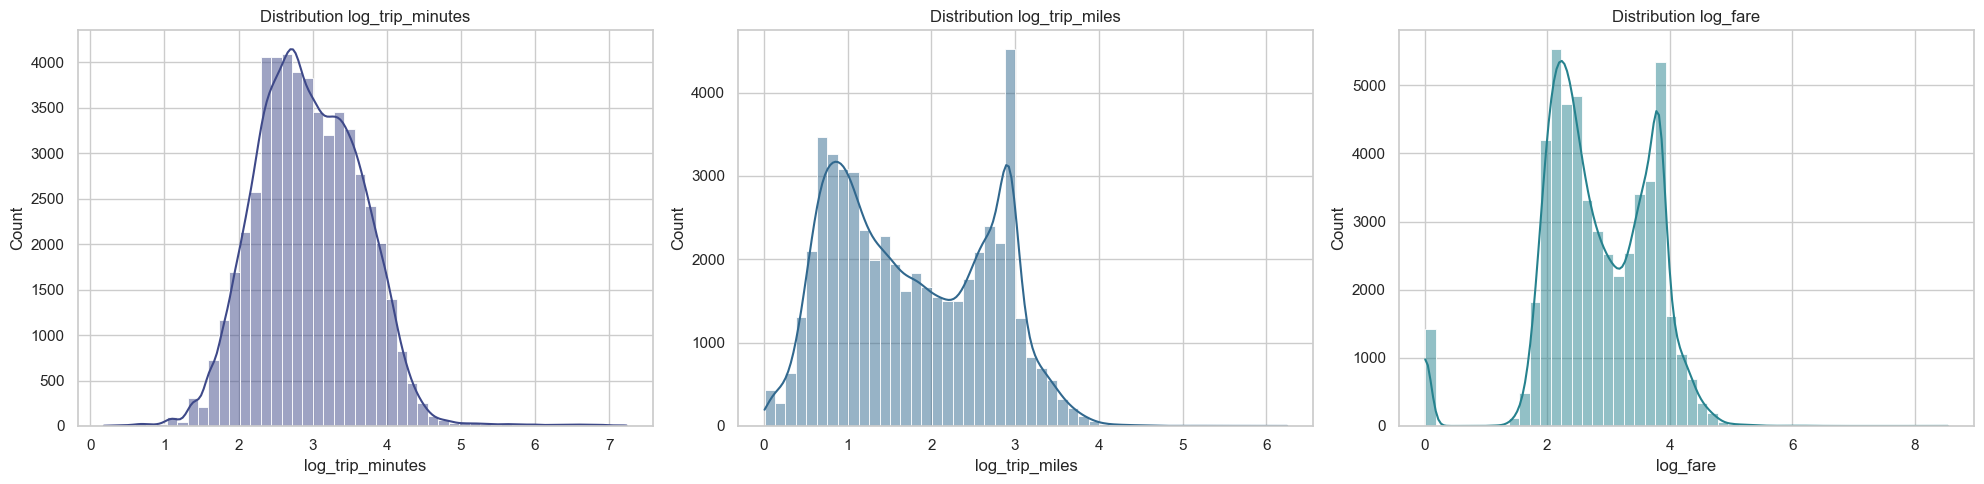

In [6]:
# %% [code]

# Appliquer la transformation log1p aux colonnes clés sur df_filtered
cols_to_log_final = ['trip_minutes', 'trip_miles', 'fare']
print("\nApplication de la transformation log1p finale...")
for col in cols_to_log_final:
    log_col_name = f'log_{col}'
    if col in df_filtered.columns:
        # S'assurer qu'il n'y a pas de négatifs (normalement déjà filtré, mais par sécurité)
        temp_series = df_filtered[col].clip(lower=0) # Forcer >= 0
        df_filtered[log_col_name] = np.log1p(temp_series)
        print(f"  Colonne '{log_col_name}' créée.")
    else:
        print(f"  Colonne '{col}' non trouvée pour transformation log.")

# Vérification rapide des distributions log
if any(f'log_{c}' in df_filtered.columns for c in cols_to_log_final):
    print("\nVisualisation rapide des distributions log transformées (après nettoyage) :")
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    log_cols_to_plot = [f'log_{c}' for c in cols_to_log_final if f'log_{c}' in df_filtered.columns]
    for i, col in enumerate(log_cols_to_plot):
         if i < len(axes):
            sns.histplot(df_filtered[col].dropna(), bins=50, kde=True, ax=axes[i], color=base_palette[i+1])
            axes[i].set_title(f'Distribution {col}')
            axes[i].set_xlabel(col)
    plt.tight_layout()
    plt.show()

# %% [markdown]

 ## 5. Étape 4 : Sélection Initiale de Features
 Choix d'un ensemble de variables jugées pertinentes pour une première tentative de modélisation du tarif.

In [7]:
# %% [code]

# Recalculer/Vérifier les features temporelles et vitesse sur le df_filtered
print("\nVérification/Création des features finales...")
# Temps
if 'trip_start_timestamp' in df_filtered.columns:
    if 'start_hour' not in df_filtered.columns: df_filtered['start_hour'] = df_filtered['trip_start_timestamp'].dt.hour
    if 'day_of_week' not in df_filtered.columns: df_filtered['day_of_week'] = df_filtered['trip_start_timestamp'].dt.dayofweek
    if 'is_weekend' not in df_filtered.columns: df_filtered['is_weekend'] = df_filtered['day_of_week'].isin([5, 6]).astype(int)
    if 'month' not in df_filtered.columns: df_filtered['month'] = df_filtered['trip_start_timestamp'].dt.month
    print("  Features temporelles vérifiées/créées.")
else:
    print("  Timestamp de début manquant, features temporelles non créées/vérifiées.")

# Vitesse Moyenne (sur données filtrées)
if 'trip_miles' in df_filtered.columns and 'trip_minutes' in df_filtered.columns:
     # Assurer que trip_minutes n'est pas nul ou négatif (normalement déjà filtré)
     valid_minutes = df_filtered['trip_minutes'].replace(0, np.nan)
     df_filtered['average_speed_mph'] = df_filtered['trip_miles'] / (valid_minutes / 60)
     df_filtered['average_speed_mph'].replace([np.inf, -np.inf, np.nan], 0, inplace=True) # Remplacer NaN/inf par 0 ou médiane?
     df_filtered['average_speed_mph'] = df_filtered['average_speed_mph'].clip(0, 100) # Clipper vitesses extrêmes
     print("  Colonne 'average_speed_mph' recalculée et clippée.")
else:
     print("  Colonnes pour vitesse manquantes, 'average_speed_mph' non recalculée.")

# Définir la variable cible et les features candidates
target = 'log_fare' # Utiliser le log du tarif comme cible

# Features candidates (Exemple)
candidate_features = [
    # Variables transformées
    'log_trip_minutes',
    'log_trip_miles',
    # Autres coûts (garder les originaux car souvent 0 ou petits montants, le log n'est pas idéal)
    'tips',
    'tolls',
    'extras',
    # Features temporelles
    'start_hour',
    'day_of_week',
    'is_weekend',
    'month',
    # Autres features
    'average_speed_mph',
    # Variables catégorielles (à encoder plus tard)
    'payment_type'
    # Ajouter d'autres si pertinentes et disponibles
]

# Garder seulement les features candidates qui existent réellement dans df_filtered
selected_features = [feat for feat in candidate_features if feat in df_filtered.columns]

# Ajouter la cible à la liste pour créer le DataFrame final
if target in df_filtered.columns:
    final_columns = [target] + selected_features
    # Créer le DataFrame final pour la modélisation
    df_final = df_filtered[final_columns].copy()
    print(f"\nSélection initiale de features effectuée. {len(selected_features)} features + 1 cible.")
    print(f"Features sélectionnées : {selected_features}")
    print(f"Forme du DataFrame final : {df_final.shape}")
else:
    print(f"Attention: Colonne cible '{target}' non trouvée. Impossible de créer df_final.")
    df_final = pd.DataFrame() # Créer un DF vide pour éviter erreurs futures


Vérification/Création des features finales...
  Features temporelles vérifiées/créées.
  Colonne 'average_speed_mph' recalculée et clippée.

Sélection initiale de features effectuée. 11 features + 1 cible.
Features sélectionnées : ['log_trip_minutes', 'log_trip_miles', 'tips', 'tolls', 'extras', 'start_hour', 'day_of_week', 'is_weekend', 'month', 'average_speed_mph', 'payment_type']
Forme du DataFrame final : (52969, 12)


# %% [markdown]

 ## 6. EDA Finale sur les Données Préparées
 Vérification rapide des caractéristiques du jeu de données final avant modélisation.


Vérification finale des NaN dans df_final:
log_fare             0
log_trip_minutes     0
log_trip_miles       0
tips                 0
tolls                0
extras               0
start_hour           0
day_of_week          0
is_weekend           0
month                0
average_speed_mph    0
payment_type         0
dtype: int64

Statistiques descriptives de df_final:
           log_fare  log_trip_minutes  log_trip_miles          tips  \
count  52969.000000      52969.000000    52969.000000  52969.000000   
mean       2.832282          2.951406        1.771965      2.189215   
std        0.875027          0.704986        0.916284      4.129799   
min        0.009950          0.182322        0.009950      0.000000   
25%        2.224624          2.446685        0.955511      0.000000   
50%        2.740840          2.907811        1.665818      0.000000   
75%        3.583519          3.452102        2.631889      2.890000   
max        8.537241          7.234394        6.247849    11

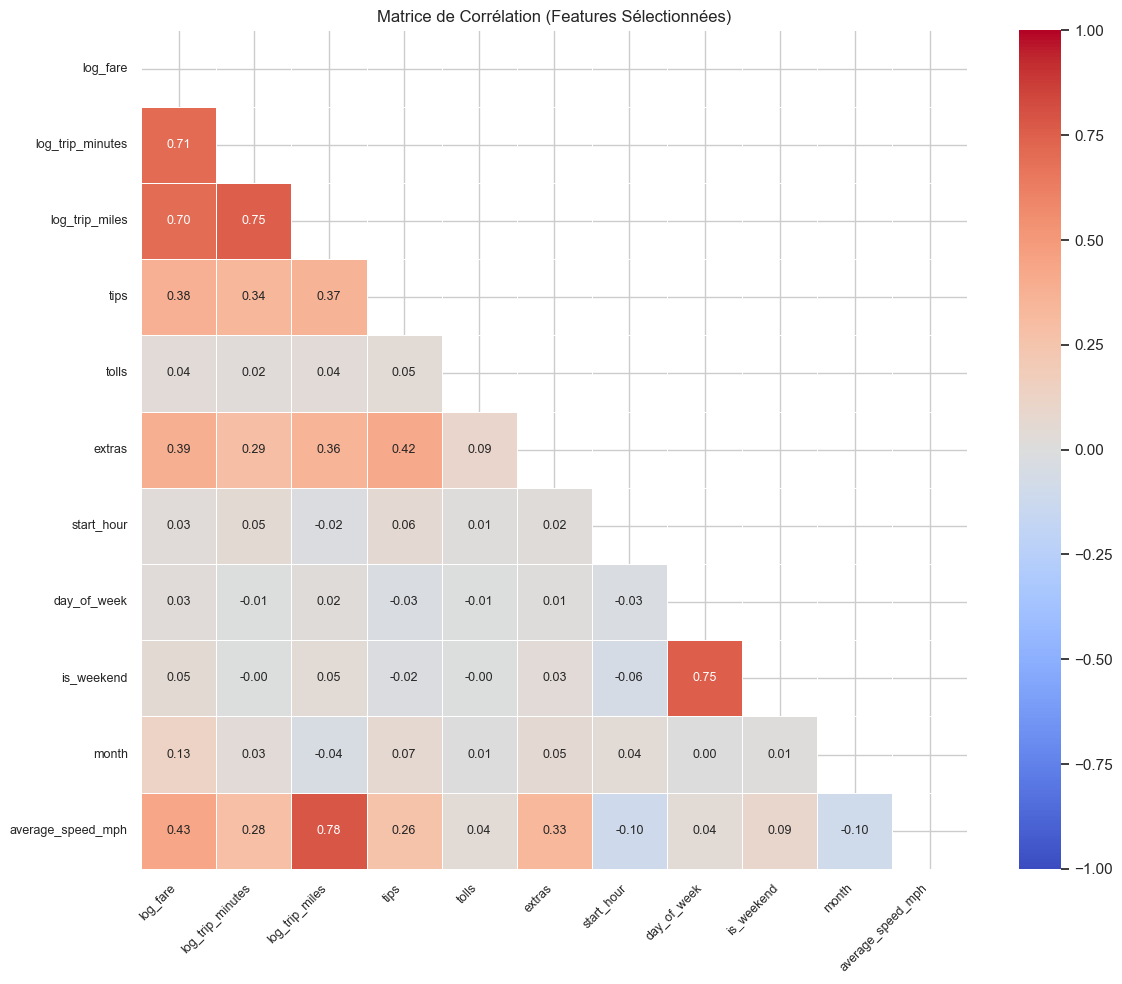


Pairplot rapide sur variables clés finales:


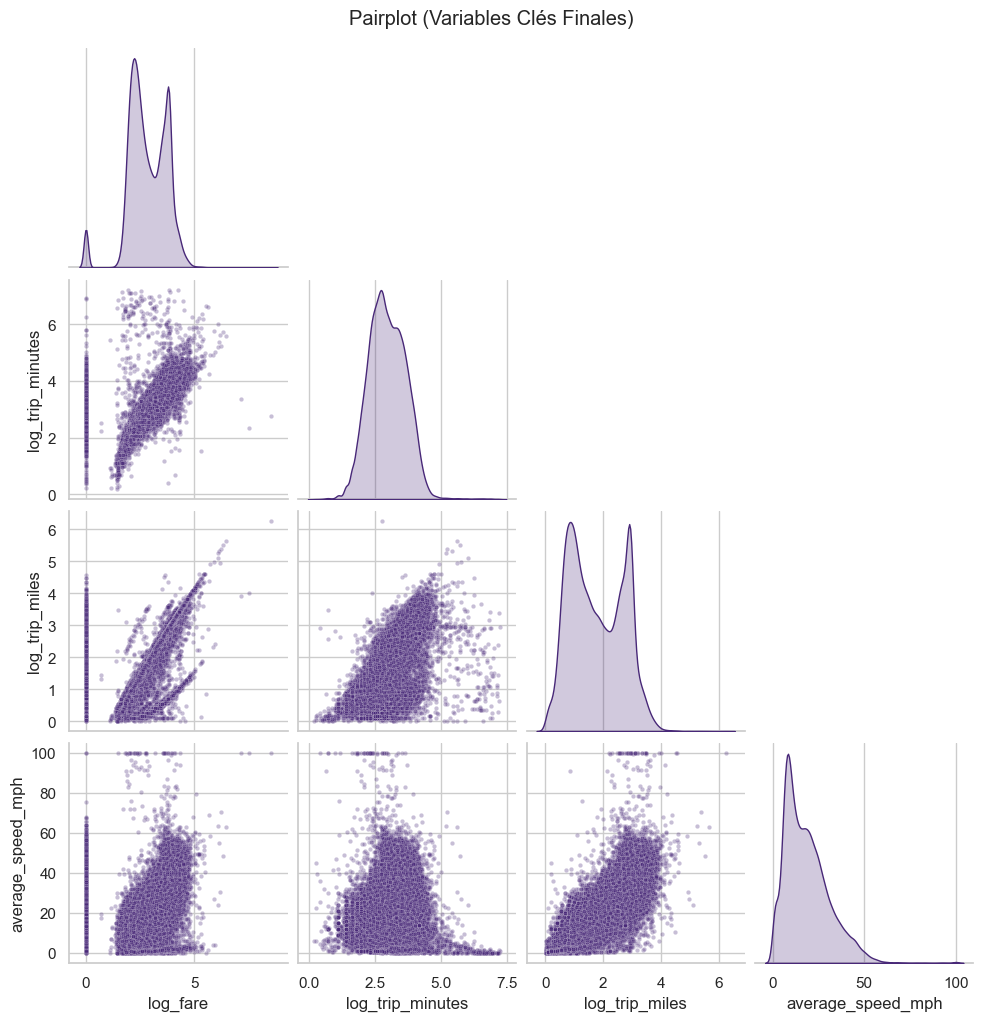

In [8]:
# %% [code]

# Vérifier s'il reste des NaN dans le DataFrame final (normalement non)
if not df_final.empty:
    print("\nVérification finale des NaN dans df_final:")
    print(df_final.isnull().sum())

    # Statistiques descriptives du jeu de données final
    print("\nStatistiques descriptives de df_final:")
    print(df_final.describe())

    # Matrice de corrélation des features sélectionnées (numériques seulement)
    print("\nMatrice de corrélation des features numériques finales:")
    numeric_final_cols = df_final.select_dtypes(include=np.number).columns
    if len(numeric_final_cols) > 1:
        corr_final = df_final[numeric_final_cols].corr()
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_final, dtype=bool))
        sns.heatmap(corr_final, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask, vmin=-1, vmax=1, annot_kws={"size":9})
        plt.title("Matrice de Corrélation (Features Sélectionnées)")
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("Pas assez de colonnes numériques pour calculer la corrélation.")

    # Pairplot rapide sur quelques variables clés transformées
    cols_for_pairplot = [c for c in [target, 'log_trip_minutes', 'log_trip_miles', 'average_speed_mph'] if c in df_final.columns]
    if len(cols_for_pairplot) > 1:
        print("\nPairplot rapide sur variables clés finales:")
        sns.pairplot(df_final[cols_for_pairplot].dropna(), corner=True, diag_kind='kde', plot_kws={'alpha':0.3, 's':10})
        plt.suptitle("Pairplot (Variables Clés Finales)", y=1.02)
        plt.show()

else:
    print("\nDataFrame final (df_final) est vide, impossible de faire l'EDA finale.")

# %% [markdown]

 ## 7. Conclusion du Pré-traitement et Prochaines Étapes

 Ce notebook a appliqué les étapes essentielles de pré-traitement identifiées lors de l'EDA :

 1.  **Filtrage :** Une part importante de l'échantillon initial a été supprimée en raison de valeurs jugées incohérentes ou non pertinentes (durée/distance/tarif nuls ou négatifs), soulignant les problèmes de qualité ou de représentativité de cet échantillon.
 2.  **Nettoyage des Manquants :** Les colonnes inutilisables (localisation, company) ont été supprimées, et les NaN restants dans les colonnes pertinentes ont été imputés (principalement avec 0 pour les coûts additionnels).
 3.  **Transformation :** Les variables clés de durée, distance et tarif ont été transformées avec `log1p` pour normaliser leur distribution et réduire l'asymétrie, ce qui est bénéfique pour de nombreux modèles.
 4.  **Sélection de Features :** Un ensemble initial de features numériques et temporelles, ainsi que le type de paiement, a été sélectionné pour une première phase de modélisation (`df_final`).

 **État Actuel des Données (`df_final`) :**
 - Le jeu de données est maintenant considérablement réduit mais théoriquement plus "propre" et focalisé sur des courses standards.
 - Il ne contient plus de valeurs manquantes.
 - Les variables numériques clés sont log-transformées.
 - Les features temporelles et la vitesse moyenne (clippée) sont incluses.
 - La variable catégorielle `payment_type` est prête pour l'encodage (ex: One-Hot Encoding).

 **Prochaines Étapes Immédiates :**

 - **Encodage Catégoriel :** Transformer la colonne `payment_type` en variables numériques (ex: One-Hot Encoding).
 - **Séparation Train/Test :** Diviser `df_final` en ensembles d'entraînement et de test.
 - **Mise à l'échelle (Scaling) :** Appliquer une mise à l'échelle (ex: StandardScaler) aux features numériques si le modèle choisi l'exige (ex: Régression Linéaire, SVM). Non nécessaire pour les modèles basés sur les arbres (Random Forest, Gradient Boosting).
 - **Modélisation Baseline :** Entraîner un ou plusieurs modèles de référence sur les données préparées pour établir une performance initiale.
 - ****(Itératif)** **Validation Croisée et Optimisation :** Affiner le modèle, potentiellement revoir la sélection de features, optimiser les hyperparamètres.
 - ****(Crucial)** **Validation sur Dataset Complet :** Appliquer le *même pipeline de pré-traitement* au dataset complet (si disponible et de meilleure qualité) et ré-entraîner/valider le modèle final. Les performances et conclusions pourraient changer radicalement avec des données plus complètes et représentatives.

 Ce notebook marque la fin de la phase d'exploration et de préparation initiale des données *de cet échantillon* et ouvre la voie à la phase de modélisation.